In [2]:
!pip install plot-keras-history -qqq

In [131]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import gc
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models, backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.preprocessing import image
from IPython.core.interactiveshell import InteractiveShell
from plot_keras_history import plot_history
from timeit import default_timer as timer
InteractiveShell.ast_node_interactivity = "all"

# Data Loading & Preprocessing

## Loading CIFAR-10 Data

In [4]:
# Load CIFAR-10 data from TensorFlow Datasets, adding to train/test sets
(x_train_full, y_train_full),(x_test, y_test)= cifar10.load_data()

print('x_train_full:\t{}'.format(x_train_full.shape))
print('y_train_full:\t{}'.format(y_train_full.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train_full:	(50000, 32, 32, 3)
y_train_full:	(50000, 1)
x_test:		(10000, 32, 32, 3)
y_test:		(10000, 1)


## Splitting & Reviewing Data

In [5]:
# Further splitting the training data into a validation set 
x_train = x_train_full[:40000]
y_train = y_train_full[:40000]
x_val = x_train_full[40000:]
y_val = y_train_full[40000:]

print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))
print('x_val:\t\t{}'.format(x_val.shape))
print('y_val:\t\t{}'.format(y_val.shape))

x_train:	(40000, 32, 32, 3)
y_train:	(40000, 1)
x_test:		(10000, 32, 32, 3)
y_test:		(10000, 1)
x_val:		(10000, 32, 32, 3)
y_val:		(10000, 1)


In [6]:
# Creating a mapping dictionary and converting numeric labels to categorical for plotting
map_dict = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}
cat_labels = [map_dict.get(i) for i in y_train.reshape(-1)]

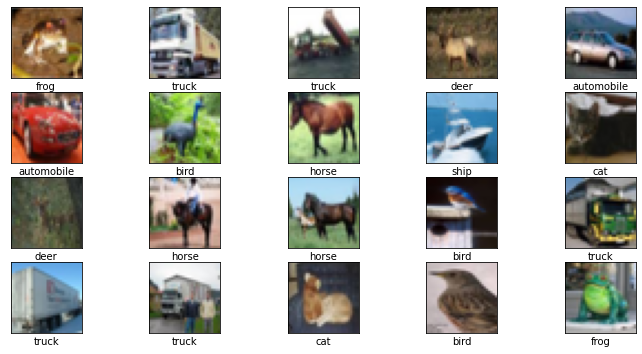

In [7]:
# Plotting the first 20 images with categorical labels
plt.figure(figsize=(12,6))
for im in range(20):
  plt.subplot(4, 5, im + 1)
  plt.imshow(x_train[im])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(cat_labels[im])
plt.show();

In [9]:
# Create a list to store model processing times for later use
model_times = []

## Preprocessing Data

In [10]:
# Reviewing unique values found in our image pixel data
print(np.unique(x_train))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [14]:
# Normalizing the values to be between 0 and 1
# Using float32 as it will default to float64 as additional memory is not necessary
x_train_norm = x_train.astype('float32')/255
x_test_norm = x_test.astype('float32')/255
x_val_norm = x_val.astype('float32')/255

x_train_norm.shape
x_test_norm.shape
x_val_norm.shape

(40000, 32, 32, 3)

(10000, 32, 32, 3)

(10000, 32, 32, 3)

# Experiment #1 - DNN with 2 layers (no regularization)

## Define & Train The Network

Fully connected network with 2 hidden layers and no regularization. 

In [15]:
model1 = models.Sequential()
model1.add(Flatten(input_shape=(32,32,3)))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(10, activation='softmax'))

model1.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model1.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                49168     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 49,610
Trainable params: 49,610
Non-trainable params: 0
_________________________________________________________________


In [16]:
start = timer()

output1 = model1.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 8s 3ms/step - loss: 2.3036 - accuracy: 0.0987 - val_loss: 2.3026 - val_accuracy: 0.0980
Epoch 2/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3028 - accuracy: 0.0998 - val_loss: 2.3028 - val_accuracy: 0.0953
Epoch 3/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3028 - accuracy: 0.1000 - val_loss: 2.3029 - val_accuracy: 0.0952
Epoch 4/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3028 - accuracy: 0.0978 - val_loss: 2.3029 - val_accuracy: 0.0952


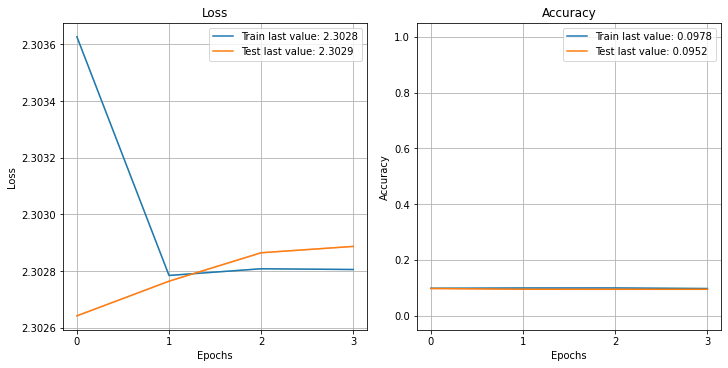

In [17]:
plot_history(output1.history);

In [21]:
# Will be using this command after each model, as the full notebook will burn my alloted Colab instance's memory. :)
gc.collect()

88

# Experiment #2 - DNN with 3 layers (no regularization)

## Define & Train The Network

Standard fully connected network with 3 hidden layers and no regularization.

In [22]:
model2 = models.Sequential()
model2.add(Flatten(input_shape=(32,32,3)))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model2.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                49168     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
Total params: 49,882
Trainable params: 49,882
Non-trainable params: 0
_________________________________________________________________


In [23]:
start = timer()

output2 = model2.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0439 - accuracy: 0.2213 - val_loss: 1.9444 - val_accuracy: 0.2639
Epoch 2/200
1250/1250 [==============================] - 5s 4ms/step - loss: 1.9025 - accuracy: 0.2898 - val_loss: 1.8970 - val_accuracy: 0.2975
Epoch 3/200
1250/1250 [==============================] - 4s 4ms/step - loss: 1.8653 - accuracy: 0.3095 - val_loss: 1.8734 - val_accuracy: 0.3164
Epoch 4/200
1250/1250 [==============================] - 5s 4ms/step - loss: 1.8434 - accuracy: 0.3201 - val_loss: 1.8471 - val_accuracy: 0.3261
Epoch 5/200
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8304 - accuracy: 0.3287 - val_loss: 1.8410 - val_accuracy: 0.3313
Epoch 6/200
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8220 - accuracy: 0.3325 - val_loss: 1.8312 - val_accuracy: 0.3311
Epoch 7/200
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8157 - accuracy: 0.3338 - val_loss: 1.8266 - val_ac

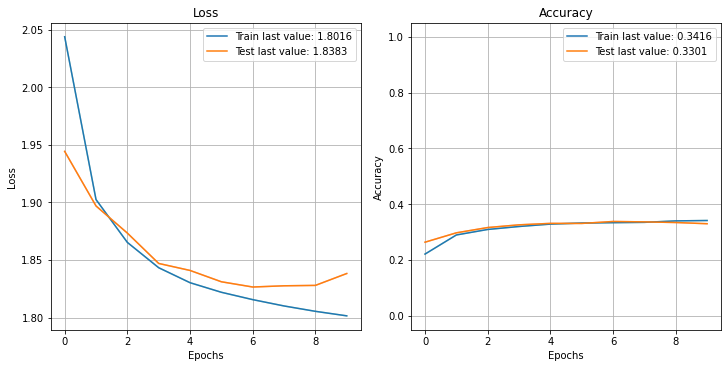

In [24]:
plot_history(output2.history);

In [27]:
gc.collect()

88

# Experiment #3 - CNN with 2 Convolutional/Max Pooling Layers (no regularization)

## Define & Train The Network

Creating a basic 2 convolutional and 2 max pooling layer CNN model with no regularization.

In [28]:
model3 = models.Sequential()
model3.add(Conv2D(32, kernel_size=(3,3),strides=(1,1), activation='relu', input_shape=(32,32,3)))
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(64, kernel_size=(3,3),strides=(1,1), activation='relu'))
model3.add(MaxPool2D(2,2))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model3.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                147520    
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [29]:
start = timer()

output3 = model3.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 35s 5ms/step - loss: 1.5210 - accuracy: 0.4519 - val_loss: 1.3038 - val_accuracy: 0.5456
Epoch 2/200
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1620 - accuracy: 0.5895 - val_loss: 1.0924 - val_accuracy: 0.6199
Epoch 3/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0191 - accuracy: 0.6460 - val_loss: 1.0726 - val_accuracy: 0.6229
Epoch 4/200
1250/1250 [==============================] - 6s 4ms/step - loss: 0.9341 - accuracy: 0.6754 - val_loss: 1.0065 - val_accuracy: 0.6502
Epoch 5/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8669 - accuracy: 0.6967 - val_loss: 1.0045 - val_accuracy: 0.6504
Epoch 6/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8143 - accuracy: 0.7187 - val_loss: 0.9544 - val_accuracy: 0.6715
Epoch 7/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7649 - accuracy: 0.7379 - val_loss: 0.9265 - val_a

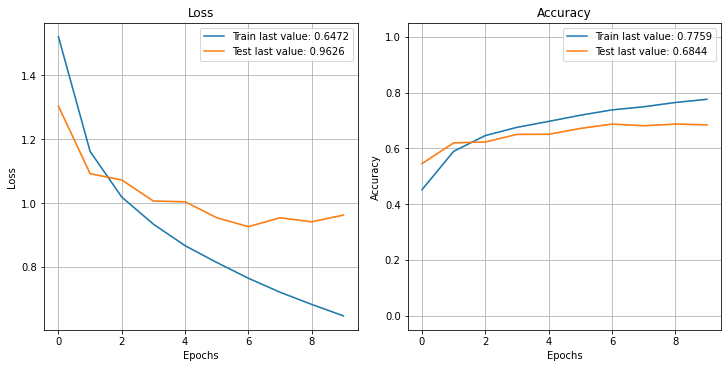

In [30]:
plot_history(output3.history);

In [42]:
gc.collect()

88

# Experiment #4 - CNN with 3 Convolutional/Max Pooling Layers (no regularization)

## Define & Train The Network

Creating a CNN with 3 convolutional and 3 max pooling layers, with no regularization.

In [43]:
model4 = models.Sequential()
model4.add(Conv2D(32, kernel_size=(3,3),strides=(1,1), activation='relu', input_shape=(32,32,3)))
model4.add(MaxPool2D(2,2))
model4.add(Conv2D(64, kernel_size=(3,3),strides=(1,1), activation='relu'))
model4.add(MaxPool2D(2,2))
model4.add(Conv2D(128, kernel_size=(3,3),strides=(1,1), activation='relu'))
model4.add(MaxPool2D(2,2))
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(10, activation='softmax'))

model4.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model4.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)              

In [44]:
start = timer()

output4 = model4.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5282 - accuracy: 0.4433 - val_loss: 1.2498 - val_accuracy: 0.5610
Epoch 2/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1397 - accuracy: 0.5990 - val_loss: 1.0535 - val_accuracy: 0.6340
Epoch 3/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9716 - accuracy: 0.6601 - val_loss: 0.9820 - val_accuracy: 0.6559
Epoch 4/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8555 - accuracy: 0.7024 - val_loss: 0.9264 - val_accuracy: 0.6817
Epoch 5/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7660 - accuracy: 0.7326 - val_loss: 0.8957 - val_accuracy: 0.6972
Epoch 6/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6932 - accuracy: 0.7574 - val_loss: 0.8750 - val_accuracy: 0.7088
Epoch 7/200
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6246 - accuracy: 0.7820 - val_loss: 0.8772 - val_ac

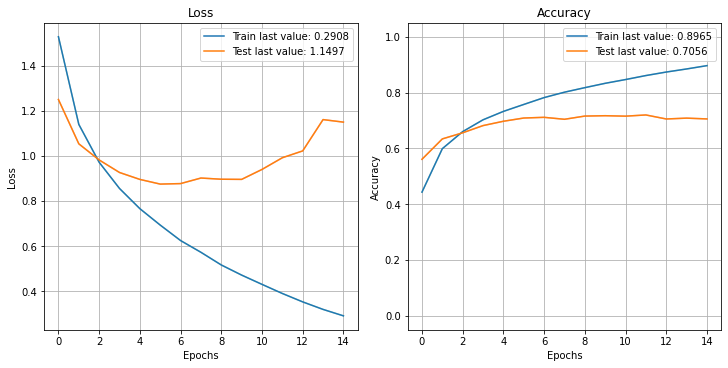

In [45]:
plot_history(output4.history);

In [49]:
gc.collect()

88

# Experiment #5 - Regularization & Tweaking

## Experiment 5A - 2 Layer DNN w/ Regularization

Revisiting the 2-layer dense network and adding L2 regularization. 

In [50]:
model5a = models.Sequential()
model5a.add(Flatten(input_shape=(32,32,3)))
model5a.add(Dense(16, activation='relu', kernel_regularizer=L2(.01)))
model5a.add(Dense(16, activation='relu', kernel_regularizer=L2(.01)))
model5a.add(Dense(10, activation='softmax'))

model5a.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model5a.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'rmsprop')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                49168     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                170       
Total params: 49,610
Trainable params: 49,610
Non-trainable params: 0
_________________________________________________________________


In [51]:
start = timer()

output5a = model5a.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.1575 - accuracy: 0.1981 - val_loss: 2.0379 - val_accuracy: 0.2506
Epoch 2/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0382 - accuracy: 0.2463 - val_loss: 2.0738 - val_accuracy: 0.2578
Epoch 3/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0212 - accuracy: 0.2658 - val_loss: 2.0839 - val_accuracy: 0.2510
Epoch 4/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0099 - accuracy: 0.2779 - val_loss: 2.0292 - val_accuracy: 0.2735
Epoch 5/200
1250/1250 [==============================] - 4s 3ms/step - loss: 2.0022 - accuracy: 0.2817 - val_loss: 2.2196 - val_accuracy: 0.2143
Epoch 6/200
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9943 - accuracy: 0.2853 - val_loss: 1.9858 - val_accuracy: 0.2981
Epoch 7/200
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9894 - accuracy: 0.2885 - val_loss: 1.9991 - val_ac

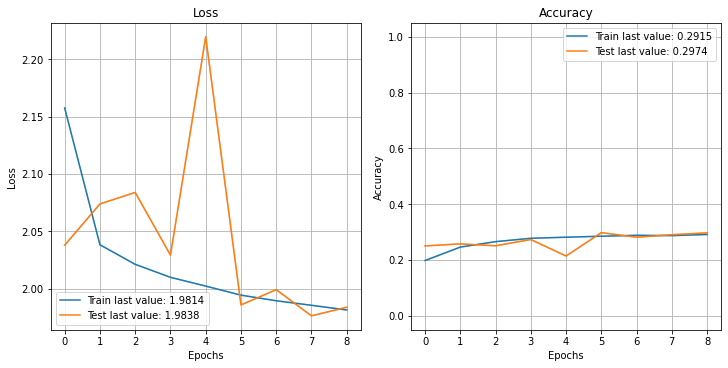

In [52]:
plot_history(output5a.history);

In [55]:
gc.collect()

88

## Experiment 5B - 3 Layer DNN w/ Regularization

Revisiting the 3-layer dense network by adding kernel regularization. L2 (ridge regression) is the selected regularization type.

In [56]:
model5b = models.Sequential()
model5b.add(Flatten(input_shape=(32,32,3)))
model5b.add(Dense(16, activation='relu', kernel_regularizer=L2(.01)))
model5b.add(Dense(16, activation='relu', kernel_regularizer=L2(.01)))
model5b.add(Dense(16, activation='relu', kernel_regularizer=L2(.01)))
model5b.add(Dense(10, activation='softmax'))

model5b.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model5b.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                49168     
_________________________________________________________________
dense_15 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_16 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                170       
Total params: 49,882
Trainable params: 49,882
Non-trainable params: 0
_________________________________________________________________


In [57]:
start = timer()

output5b = model5b.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 6s 4ms/step - loss: 2.2618 - accuracy: 0.1651 - val_loss: 2.1565 - val_accuracy: 0.1805
Epoch 2/200
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1415 - accuracy: 0.1793 - val_loss: 2.1444 - val_accuracy: 0.1809
Epoch 3/200
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1199 - accuracy: 0.1837 - val_loss: 2.1130 - val_accuracy: 0.1818
Epoch 4/200
1250/1250 [==============================] - 5s 4ms/step - loss: 2.1075 - accuracy: 0.1842 - val_loss: 2.1021 - val_accuracy: 0.1894
Epoch 5/200
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0988 - accuracy: 0.1854 - val_loss: 2.1281 - val_accuracy: 0.1750
Epoch 6/200
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0932 - accuracy: 0.1844 - val_loss: 2.1022 - val_accuracy: 0.1888
Epoch 7/200
1250/1250 [==============================] - 4s 4ms/step - loss: 2.0867 - accuracy: 0.1875 - val_loss: 2.0920 - val_ac

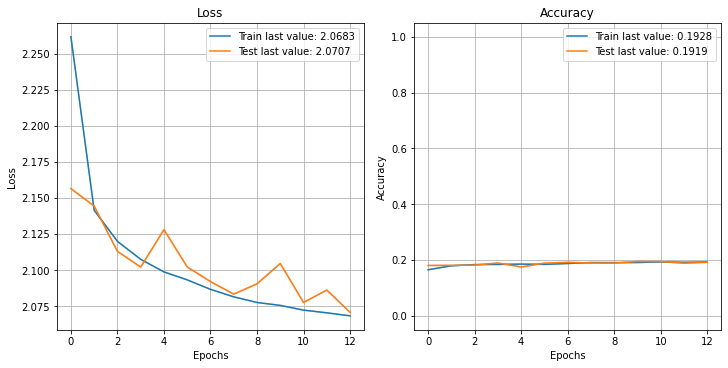

In [58]:
plot_history(output5b.history);

In [60]:
gc.collect()

88

## Experiment 5C - 2 Layer CNN/Max Pooling w/ Regularization

Revisiting the 2-layer CNN by adding dropout layers for regularization.

In [68]:
model5c = models.Sequential()
model5c.add(Conv2D(32, kernel_size=(3,3),strides=(1,1), activation='relu', input_shape=(32,32,3)))
model5c.add(MaxPool2D(2,2))
model5c.add(Dropout(.5))
model5c.add(Conv2D(64, kernel_size=(3,3),strides=(1,1), activation='relu'))
model5c.add(MaxPool2D(2,2))
model5c.add(Dropout(.5))
model5c.add(Flatten())
model5c.add(Dense(64, activation='relu'))
model5c.add(Dense(10, activation='softmax'))

model5c.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model5c.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 2304)             

In [73]:
start = timer()

output5c = model5c.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4470 - accuracy: 0.4773 - val_loss: 1.3322 - val_accuracy: 0.5253
Epoch 2/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2939 - accuracy: 0.5366 - val_loss: 1.1932 - val_accuracy: 0.5989
Epoch 3/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2051 - accuracy: 0.5719 - val_loss: 1.1246 - val_accuracy: 0.6144
Epoch 4/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1482 - accuracy: 0.5942 - val_loss: 1.0769 - val_accuracy: 0.6290
Epoch 5/200
1250/1250 [==============================] - 6s 4ms/step - loss: 1.1125 - accuracy: 0.6078 - val_loss: 1.0431 - val_accuracy: 0.6560
Epoch 6/200
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0793 - accuracy: 0.6174 - val_loss: 0.9967 - val_accuracy: 0.6591
Epoch 7/200
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0514 - accuracy: 0.6297 - val_loss: 1.0063 - val_ac

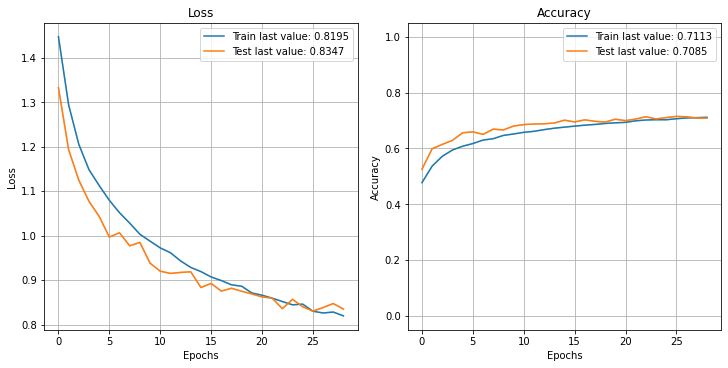

In [74]:
plot_history(output5c.history);

In [77]:
gc.collect()

88

## Experiment 5D - 3 Layer CNN/Max Pooling w/ Regularization

Revisiting the 3-layer CNN by adding regularization though dropout layers.

In [78]:
model5d = models.Sequential()
model5d.add(Conv2D(32, kernel_size=(3,3),strides=(1,1), activation='relu', input_shape=(32,32,3)))
model5d.add(MaxPool2D(2,2))
model5d.add(Dropout(.5))
model5d.add(Conv2D(64, kernel_size=(3,3),strides=(1,1), activation='relu'))
model5d.add(MaxPool2D(2,2))
model5d.add(Dropout(.5))
model5d.add(Conv2D(128, kernel_size=(3,3),strides=(1,1), activation='relu'))
model5d.add(MaxPool2D(2,2))
model5d.add(Dropout(.5))
model5d.add(Flatten())
model5d.add(Dense(64, activation='relu'))
model5d.add(Dense(10, activation='softmax'))

model5d.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model5d.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)        

In [79]:
start = timer()

output5d = model5d.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 8s 5ms/step - loss: 1.7996 - accuracy: 0.3310 - val_loss: 1.5324 - val_accuracy: 0.4525
Epoch 2/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4775 - accuracy: 0.4624 - val_loss: 1.3856 - val_accuracy: 0.5250
Epoch 3/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3746 - accuracy: 0.5039 - val_loss: 1.2990 - val_accuracy: 0.5341
Epoch 4/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3146 - accuracy: 0.5226 - val_loss: 1.2189 - val_accuracy: 0.5874
Epoch 5/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2781 - accuracy: 0.5390 - val_loss: 1.2383 - val_accuracy: 0.5677
Epoch 6/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2429 - accuracy: 0.5529 - val_loss: 1.1791 - val_accuracy: 0.5871
Epoch 7/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2259 - accuracy: 0.5615 - val_loss: 1.1362 - val_ac

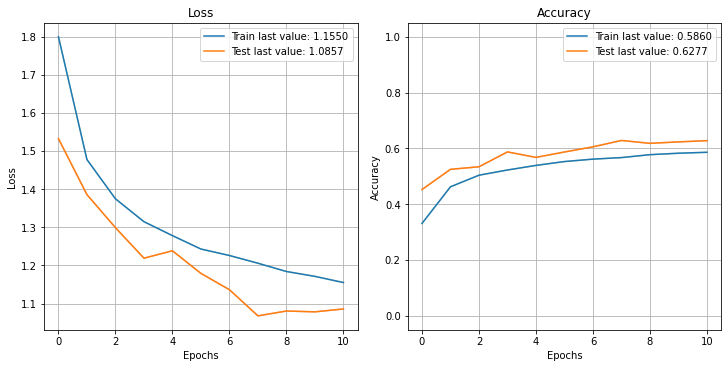

In [80]:
plot_history(output5d.history);

In [82]:
gc.collect()

88

## Experiment 5E - Modified Architecture & Regularization

Modifying the filter counters for the convolutiona layers, and adding another Dense layer to determine the shift in adding a fully connected layer. 

In [83]:
model5e = models.Sequential()
model5e.add(Conv2D(64, kernel_size=(3,3),strides=(1,1), activation='relu', input_shape=(32,32,3)))
model5e.add(MaxPool2D(2,2))
model5e.add(Dropout(.2))
model5e.add(Conv2D(64, kernel_size=(3,3),strides=(1,1), activation='relu'))
model5e.add(MaxPool2D(2,2))
model5e.add(Dropout(.2))
model5e.add(Conv2D(64, kernel_size=(3,3),strides=(1,1), activation='relu'))
model5e.add(MaxPool2D(2,2))
model5e.add(Dropout(.2))
model5e.add(Flatten())
model5e.add(Dense(64, activation='relu', kernel_regularizer=L2(.01)))
model5e.add(Dense(32, activation='relu', kernel_regularizer=L2(.01)))
model5e.add(Dense(10, activation='softmax'))

model5e.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model5e.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)         

In [84]:
start = timer()

output5e = model5e.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb] 
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 8s 5ms/step - loss: 1.9354 - accuracy: 0.3403 - val_loss: 1.5474 - val_accuracy: 0.4651
Epoch 2/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5060 - accuracy: 0.4794 - val_loss: 1.3906 - val_accuracy: 0.5315
Epoch 3/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3800 - accuracy: 0.5318 - val_loss: 1.2778 - val_accuracy: 0.5703
Epoch 4/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2978 - accuracy: 0.5634 - val_loss: 1.2411 - val_accuracy: 0.5875
Epoch 5/200
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2401 - accuracy: 0.5851 - val_loss: 1.1685 - val_accuracy: 0.6088
Epoch 6/200
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1907 - accuracy: 0.6052 - val_loss: 1.1086 - val_accuracy: 0.6370
Epoch 7/200
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1540 - accuracy: 0.6159 - val_loss: 1.0618 - val_ac

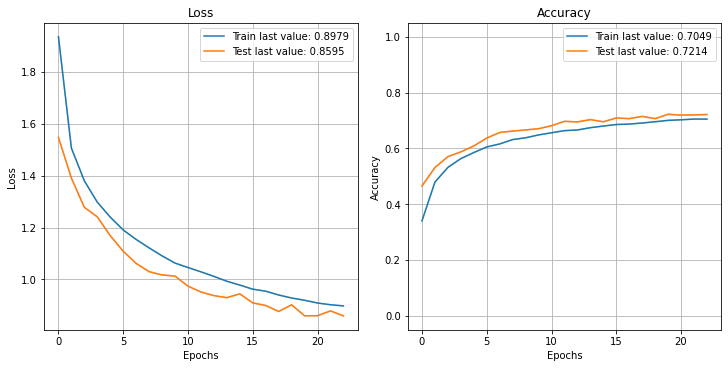

In [85]:
plot_history(output5e.history);

In [87]:
gc.collect()

88

## Experiment 5F - Modified Filter Counts

Maintaining the same architecture/layer count, only changing the number of filters to be quite a bit higher than before, as well as the nodes in the dense layers. The hope is to determine if a more complex network, that is slower to train, is worth its weight (no pun intended). 

In [88]:
model5f = models.Sequential()
model5f.add(Conv2D(256, kernel_size=(3,3),strides=(1,1), activation='relu', input_shape=(32,32,3)))
model5f.add(MaxPool2D(2,2))
model5f.add(Dropout(.2))
model5f.add(Conv2D(256, kernel_size=(3,3),strides=(1,1), activation='relu'))
model5f.add(MaxPool2D(2,2))
model5f.add(Dropout(.2))
model5f.add(Conv2D(256, kernel_size=(3,3),strides=(1,1), activation='relu'))
model5f.add(MaxPool2D(2,2))
model5f.add(Dropout(.2))
model5f.add(Flatten())
model5f.add(Dense(128, activation='relu', kernel_regularizer=L2(.01)))
model5f.add(Dense(128, activation='relu', kernel_regularizer=L2(.01)))
model5f.add(Dense(10, activation='softmax'))

model5f.summary()

earlystopcb = EarlyStopping(monitor='val_accuracy', patience=3)

model5f.compile(loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'Nadam')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 256)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)       

In [89]:
start = timer()

output5f = model5f.fit(
    x_train_norm,
    y_train,
    epochs = 200,
    validation_data = (x_val_norm, y_val),
    callbacks=[earlystopcb]
    )

end = timer()
model_times.append(end-start)

Epoch 1/200
1250/1250 [==============================] - 15s 11ms/step - loss: 1.9169 - accuracy: 0.3633 - val_loss: 1.4454 - val_accuracy: 0.5046
Epoch 2/200
1250/1250 [==============================] - 13s 11ms/step - loss: 1.3741 - accuracy: 0.5344 - val_loss: 1.2397 - val_accuracy: 0.5981
Epoch 3/200
1250/1250 [==============================] - 13s 10ms/step - loss: 1.2122 - accuracy: 0.6013 - val_loss: 1.0965 - val_accuracy: 0.6448
Epoch 4/200
1250/1250 [==============================] - 13s 10ms/step - loss: 1.1085 - accuracy: 0.6413 - val_loss: 1.0052 - val_accuracy: 0.6858
Epoch 5/200
1250/1250 [==============================] - 13s 10ms/step - loss: 1.0304 - accuracy: 0.6690 - val_loss: 0.9923 - val_accuracy: 0.6812
Epoch 6/200
1250/1250 [==============================] - 13s 10ms/step - loss: 0.9715 - accuracy: 0.6892 - val_loss: 0.9409 - val_accuracy: 0.7047
Epoch 7/200
1250/1250 [==============================] - 13s 10ms/step - loss: 0.9230 - accuracy: 0.7086 - val_loss: 0

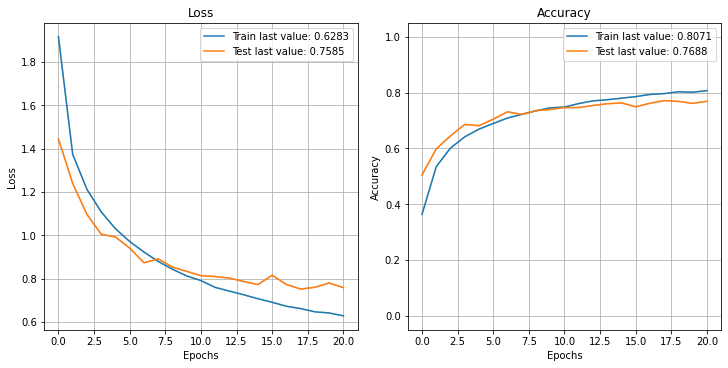

In [90]:
plot_history(output5f.history);

In [92]:
gc.collect()

88

# Results

In [94]:
# Creating a list of the different model histories for easy iteration
historylist = [output1.history, output2.history, output3.history,
               output4.history, output5a.history, output5b.history,
               output5c.history, output5d.history, output5e.history,
               output5f.history]

In [144]:
# Generating a DataFrame to see the different model accuracy and loss values, as well as their training execution times 
resultsdf = pd.DataFrame()
resultsdf['model'] = ['dnn_2layer','dnn_3layer','cnn_2layer','cnn_3layer',
                      'dnn_2layer_reg','dnn_3layer_reg','cnn_2layer_reg','cnn_3layer_reg',
                      'cnn_modifiedarch_reg','cnn_modifiednodes_reg']
resultsdf['train_accuracy'] = [max(m['accuracy']) for m in historylist]
resultsdf['train_loss'] = [max(m['loss']) for m in historylist]
resultsdf['val_accuracy'] = [max(m['val_accuracy']) for m in historylist]
resultsdf['val_loss'] = [max(m['val_loss']) for m in historylist]
resultsdf['model_execution_times'] = model_times
resultsdf

,model,train_accuracy,train_loss,val_accuracy,val_loss,model_execution_times
0,dnn_2layer,0.099950,2.303627,0.0980,2.302887,19.777184
1,dnn_3layer,0.341600,2.043862,0.3381,1.944356,45.207163
2,cnn_2layer,0.775900,1.521042,0.6871,1.303789,87.840759
3,cnn_3layer,0.896525,1.528171,0.7198,1.249843,91.960399
4,dnn_2layer_reg,0.291525,2.157512,0.2981,2.219592,34.088132
5,dnn_3layer_reg,0.193350,2.261776,0.1946,2.156517,63.003769
6,cnn_2layer_reg,0.711325,1.446998,0.7147,1.332172,165.051940
7,cnn_3layer_reg,0.586025,1.799551,0.6284,1.532414,69.227242
8,cnn_modifiedarch_reg,0.705100,1.935448,0.7222,1.547369,152.497822
9,cnn_modifiednodes_reg,0.807100,1.916885,0.7712,1.445415,275.030795


# Feature Map Visualization

This section involves reusing code from the course-provided notebook, shifting which image is being visualized and reviewed. The intent is to "see" what the feature maps are identifying from the image and how the identified areas shift after being passed through pooling layers. 

(-0.5, 31.5, 31.5, -0.5)

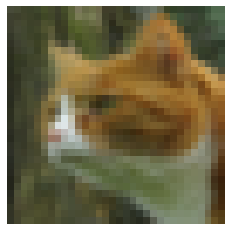

In [137]:
img = x_test[91]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [138]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model3.layers[:4]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model3.input, outputs=layer_outputs)

In [142]:
activations = activation_model.predict(img_tensor)
len(activations)

4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning:

invalid value encountered in true_divide



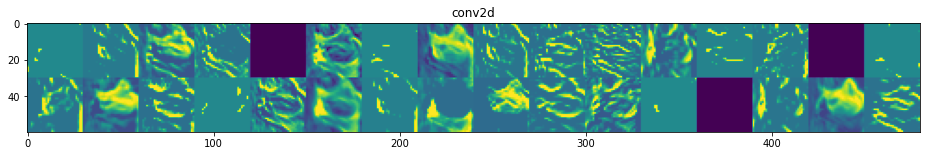

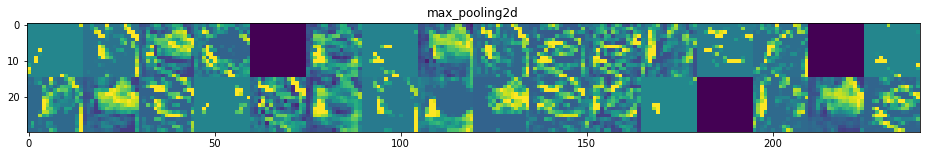

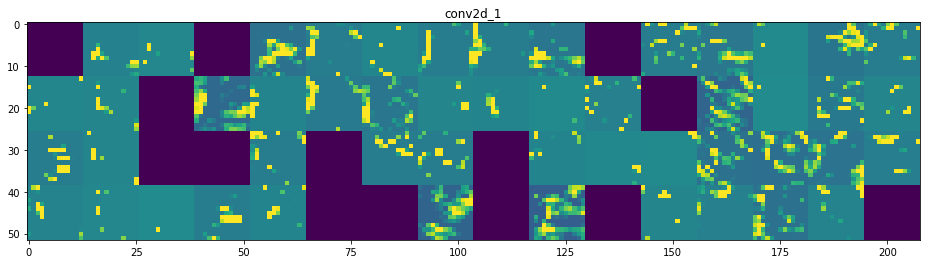

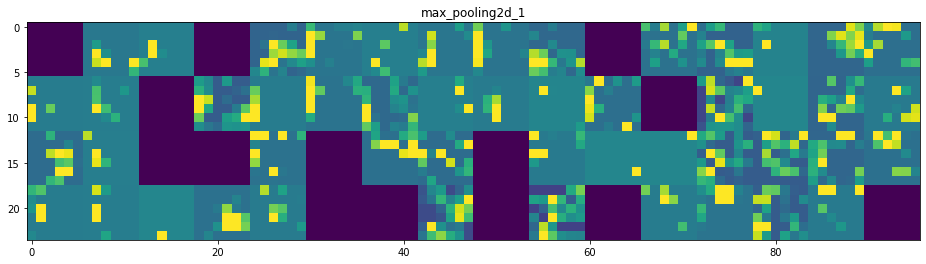

In [143]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model3.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();